<a href="https://colab.research.google.com/github/insibalas/100-Days-Of-DataScience/blob/main/Task1_1_Forecasting_Walmart_Sales_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Walmart Sales with Machine Learning

# Importing modules

In [1]:
!pip install pandas numpy matplotlib seaborn plotly scikit-learn jovian opendatasets graphviz --upgrade --quiet

# Installing libraries

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size']=14
matplotlib.rcParams['figure.figsize'] = (10,8)

# Downloading the data from Kaggle

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/data'

try:
    od.download(dataset_url)
    print("Dataset downloaded successfully")
except Exception as e:
    print(f"Error occurred: {str(e)}")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sivashankarb
Your Kaggle Key: ··········


100%|██████████| 2.70M/2.70M [00:01<00:00, 2.41MB/s]


Extracting archive ./walmart-recruiting-store-sales-forecasting/walmart-recruiting-store-sales-forecasting.zip to ./walmart-recruiting-store-sales-forecasting
Dataset downloaded successfully


# Unzipping all the files

In [4]:
import os
import zipfile
import glob

for file in glob.glob("walmart-recruiting-store-sales-forecasting/*.zip"):
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall("data/")

# Reading the input files with pandas

In [5]:
def return_df(file):

    return pd.read_csv(file, header = 0)

stores = return_df("/content/walmart-recruiting-store-sales-forecasting/stores.csv")
features = return_df("/content/data/features.csv")
train = return_df("/content/data/train.csv")
test = return_df("/content/data/train.csv")

In [6]:
display(features.sample(5).sort_values(by='Store').reset_index(drop=True))

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,24,2012-09-28,58.86,4.158,11941.13,15.28,21.76,984.11,7013.13,138.739500,8.953,False
1,28,2013-01-18,36.49,3.545,4908.90,1569.20,1.02,296.82,5466.87,132.030871,9.910,False
2,38,2013-02-15,47.12,3.924,792.76,300.95,0.24,NaN,1335.23,132.272571,9.910,False
3,39,2010-02-26,49.79,2.561,NaN,NaN,NaN,NaN,NaN,210.077189,8.554,False
4,43,2010-02-05,47.31,2.572,NaN,NaN,NaN,NaN,NaN,203.064274,9.521,False


In [7]:
display(train.sample(5).sort_values(by='Store').reset_index(drop=True))

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,4,82,2011-10-14,30170.98,False
1,6,37,2010-10-08,3997.06,False
2,6,22,2011-04-15,15289.59,False
3,10,87,2011-11-18,23537.43,False
4,32,4,2010-11-05,27415.91,False


In [8]:
display(test.sample(5).sort_values(by='Store').reset_index(drop=True))

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,12,91,2011-03-25,6564.67,False
1,18,11,2011-08-26,21373.00,False
2,19,29,2011-06-17,4557.92,False
3,20,11,2010-09-03,22063.19,False
4,25,74,2012-10-26,9984.12,False


# Data Preprocessing

### Merging features and stores dataframe with train and test data

In [9]:
features = features.merge(stores, how = 'left', on = 'Store')

def return_merged_data(data):

    df = data.merge(features, how = 'left', on = ['Store','Date','IsHoliday']).sort_values(by=['Store','Dept','Date']).reset_index(drop=True)
    return df

In [10]:
train_data, test_data = return_merged_data(train), return_merged_data(test)

In [11]:
display(train_data.sample(5).sort_values(by = 'Store').reset_index(drop = True))

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,6,85,2012-09-14,1884.23,False,76.41,3.717,11072.87,22.00,6.01,3871.46,9997.93,224.200468,5.668,A,202505
1,10,50,2010-09-10,3750.00,True,84.04,2.961,NaN,NaN,NaN,NaN,NaN,126.114581,9.199,B,126512
2,31,37,2011-12-23,3278.06,False,46.54,3.112,2240.27,18.26,974.28,86.00,6207.39,218.999550,7.441,A,203750
3,40,71,2010-09-10,2721.88,True,62.75,2.717,NaN,NaN,NaN,NaN,NaN,132.756452,5.326,A,155083
4,42,31,2010-10-22,39.00,False,68.12,3.014,NaN,NaN,NaN,NaN,NaN,126.381548,9.003,C,39690


### Converting IsHoliday boolean data to 0 if False and 1 if True

In [12]:
def convert_boolean(data):
    data['IsHoliday'] = data['IsHoliday'].map({False : 0, True : 1}).astype('int')
    return data

In [13]:
train_data, test_data = convert_boolean(train_data), convert_boolean(test_data)

### Checking for missing/nan values

In [14]:
train_data.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

### Replacing nan values with 0

In [15]:
def replace_nan(data):

    columns_to_fill = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
    data[columns_to_fill] = data[columns_to_fill].fillna(0)

    return data

In [16]:
train_data, test_data = replace_nan(train_data), replace_nan(test_data)

In [17]:
train_data, test_data = replace_nan(train_data), replace_nan(test_data)

In [18]:
train_data.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,A,151315


## Feature Engineering

### Extracting date information from the Date column

In [19]:
def extract_date_info(df):
    df['Date2'] = pd.to_datetime(df['Date'])

    df['Day'] = df['Date2'].dt.day.astype('int')
    df['Month'] = df['Date2'].dt.month.astype('int')
    df['Year'] = df['Date2'].dt.year.astype('int')
#     df['DayOfWeek'] = df['Date2'].dt.weekday
    df['WeekOfYear'] = df['Date2'].dt.isocalendar().week.astype('int')
    df['Quarter'] = df['Date2'].dt.quarter.astype('int')
    df = df.drop(columns = ['Date2'])


    return df

In [20]:
train_data, test_data = extract_date_info(train_data), extract_date_info(test_data)

### Data Summary Statistics

In [21]:
train_data.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Day,Month,Year,WeekOfYear,Quarter
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,0.070358,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,15.673131,6.449510,2010.968591,25.826762,2.482767
std,12.785297,30.492054,22711.183519,0.255750,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,8.753549,3.243217,0.796876,14.151887,1.071341
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,1.000000,1.000000,2010.000000,1.000000,1.000000
25%,11.000000,18.000000,2079.650000,0.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,8.000000,4.000000,2010.000000,14.000000,2.000000
50%,22.000000,37.000000,7612.030000,0.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,16.000000,6.000000,2011.000000,26.000000,2.000000
75%,33.000000,74.000000,20205.852500,0.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,23.000000,9.000000,2012.000000,38.000000,3.000000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,31.000000,12.000000,2012.000000,52.000000,4.000000


We observe that there are some negative MarkDown(1-5) values. We shall drop those columns and add a new column with the sum of all MarkDown values

### Adding all MarkDown(1-5) values into a new columns MarkDown

In [22]:
def markdown_info(df):

    # Drop rows with negative values in the specified columns
    negative_mask = (df['MarkDown1'] < 0) | (df['MarkDown2'] < 0) | (df['MarkDown3'] < 0) | (df['MarkDown4'] < 0) | (df['MarkDown5'] < 0)
    df = df[~negative_mask].copy()

    # Create a new column 'MarkDown' with the sum of values from the 5 columns
    df['MarkDown'] = df['MarkDown1'] + df['MarkDown2'] + df['MarkDown3'] + df['MarkDown4'] + df['MarkDown5']
    df.drop(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], axis=1, inplace=True)

    return df


In [23]:
train_data, test_data = markdown_info(train_data), markdown_info(test_data)

### Add national holiday information

Common week numbers for holidays in all four years:

- Week 1: New Year's Day (2010, 2011, 2012, 2013)
- Week 3: Martin Luther King Jr. Day (2010, 2011, 2012)
- Week 6: Super Bowl
- Week 8: Presidents Day (2011, 2012, 2013)
- Week 22: Memorial Day (2010, 2011, 2012)
- Week 27: Independence Day (2010, 2011, 2012)
- Week 36: Labor Day (2010, 2011, 2012)
- Week 41: Columbus Day (2010, 2011, 2012)
- Week 46: Veterans Day (2010, 2011, 2012)
- Week 47: Thanksgiving Day (2010, 2011, 2012)
- Week 52: Christmas Day (2010, 2011, 2012, 2013)

In [24]:
def isholiday(df):

    holiday_weeks = [1, 3, 6, 8, 22, 27, 36, 41, 46, 47, 52]
    df.loc[df['WeekOfYear'].isin(holiday_weeks), 'IsHoliday'] = 1

    return df

In [25]:
train_data, test_data = isholiday(train_data), isholiday(test_data)

In [26]:
train_data.describe()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Size,Day,Month,Year,WeekOfYear,Quarter,MarkDown
count,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000,420002.000000
mean,22.202313,44.261096,15977.012057,0.195675,60.051672,3.359440,171.191765,7.961780,136663.325958,15.670078,6.448869,2010.964850,25.822751,2.482757,6662.780048
std,12.788603,30.493472,22708.064554,0.396720,18.454997,0.458382,39.155797,1.863742,60998.190179,8.752357,3.246059,0.795935,14.165545,1.072177,14770.313813
min,1.000000,1.000000,-4988.940000,0.000000,-2.060000,2.472000,126.064000,3.879000,34875.000000,1.000000,1.000000,2010.000000,1.000000,1.000000,0.000000
25%,11.000000,18.000000,2078.292500,0.000000,46.660000,2.931000,132.022667,6.891000,93638.000000,8.000000,4.000000,2010.000000,14.000000,2.000000,0.000000
50%,22.000000,37.000000,7610.035000,0.000000,62.060000,3.452000,182.318780,7.866000,140167.000000,16.000000,6.000000,2011.000000,26.000000,2.000000,0.000000
75%,33.000000,74.000000,20202.157500,0.000000,74.250000,3.737000,212.412888,8.572000,202505.000000,23.000000,9.000000,2012.000000,38.000000,3.000000,7990.170000
max,45.000000,99.000000,693099.360000,1.000000,100.140000,4.468000,227.232807,14.313000,219622.000000,31.000000,12.000000,2012.000000,52.000000,4.000000,160510.610000


In [27]:
train_data = train_data.sort_values(by=['Date']).reset_index(drop=True)
test_data = test_data.sort_values(by=['Date']).reset_index(drop=True)

# Exploratory Data Analysis

### Let us explore the trends between several input columns and target column Weeky_Sales

In [28]:
sns.heatmap(train_data[numeric_cols+target_col].corr().round(decimals=2), annot = True)

NameError: name 'numeric_cols' is not defined

### Histogram of Weekly_Sales

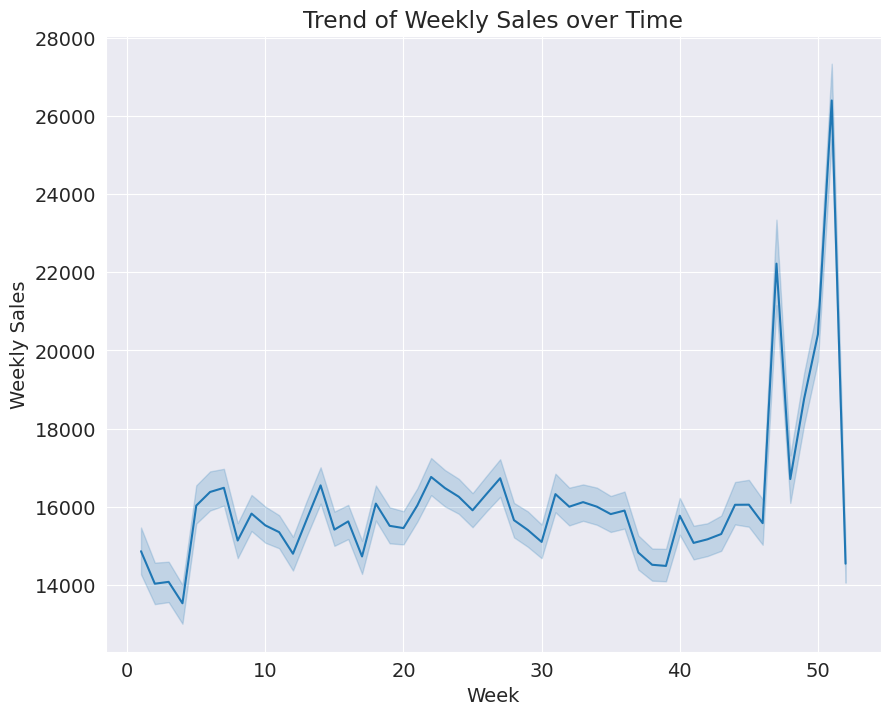

In [29]:
sns.lineplot(data=train_data, x='WeekOfYear', y='Weekly_Sales')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.title('Trend of Weekly Sales over Time')
plt.show()

**Insights** - There seems to be a major spike during Thanksgiving and Chrismas weeks

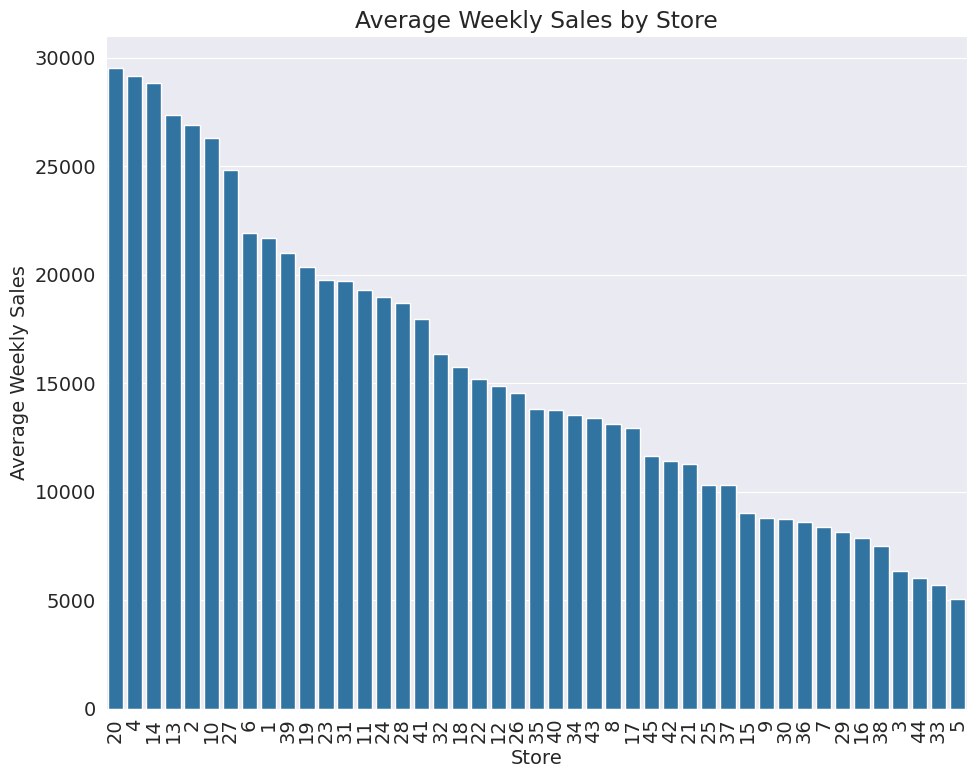

In [30]:
avg_sales_by_store = train_data.groupby('Store')['Weekly_Sales'].mean().reset_index()
sns.barplot(data=avg_sales_by_store, x='Store', y='Weekly_Sales',
            order = avg_sales_by_store.sort_values('Weekly_Sales',ascending = False)['Store'])
plt.xlabel('Store')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Store')
plt.xticks(rotation=90)  # Rotate X-axis labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent label overlapping
plt.show()

**Insights** - The top 5 stores with high average weekly sales are 20,4,14,13,2

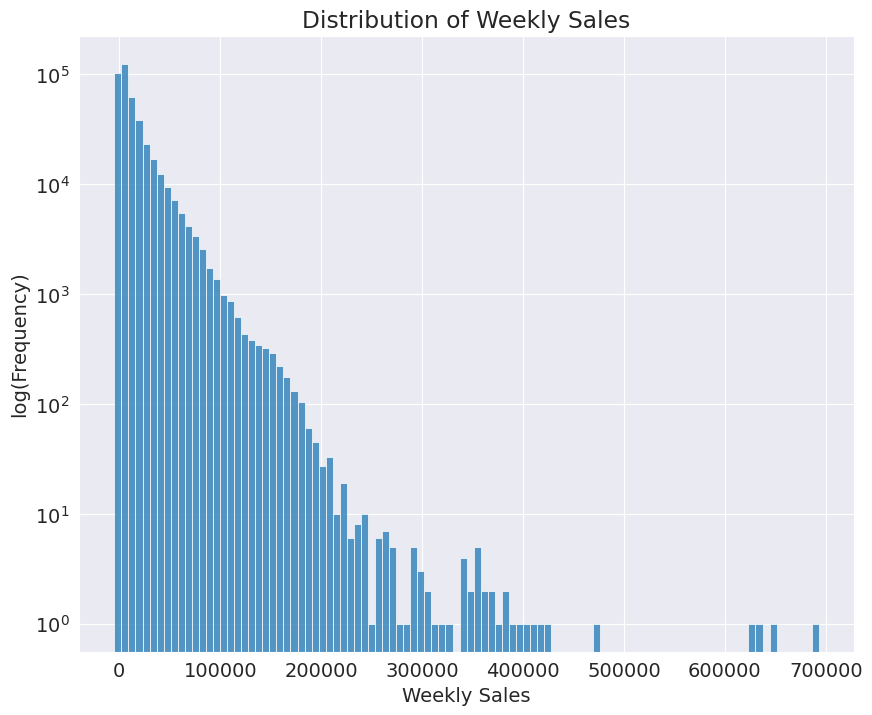

In [31]:
sns.histplot(data=train_data, x='Weekly_Sales', bins=100)
plt.xlabel('Weekly Sales')
plt.ylabel('log(Frequency)')
plt.yscale('log')
plt.title('Distribution of Weekly Sales')
plt.show()

**Insights** - There are more occurences of weekly sales in the lower end than the high numbers.

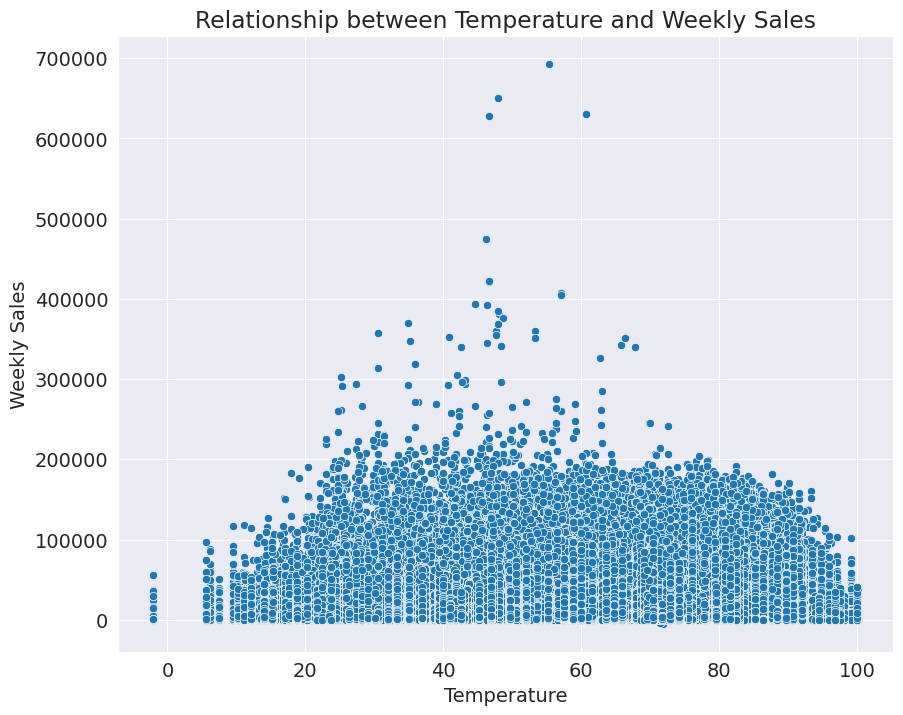

In [32]:
sns.scatterplot(data=train_data, x='Temperature', y='Weekly_Sales')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.title('Relationship between Temperature and Weekly Sales')
plt.show()

**Insights** - High weekly sales seem to be recorded when temperatures are pleasant - in the range 30-70 Fahrenheit

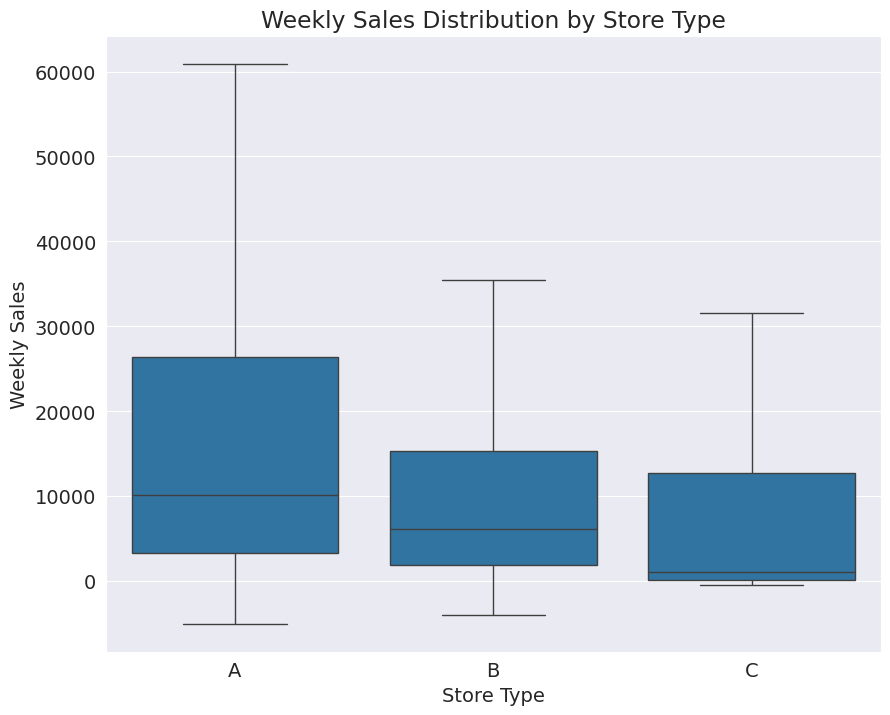

In [33]:
sns.boxplot(data=train_data, x='Type', y='Weekly_Sales',showfliers = False)
plt.xlabel('Store Type')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Distribution by Store Type')
plt.show()

**Insights** - Store Type A seems to have higher weekly sales, followed by B and then C

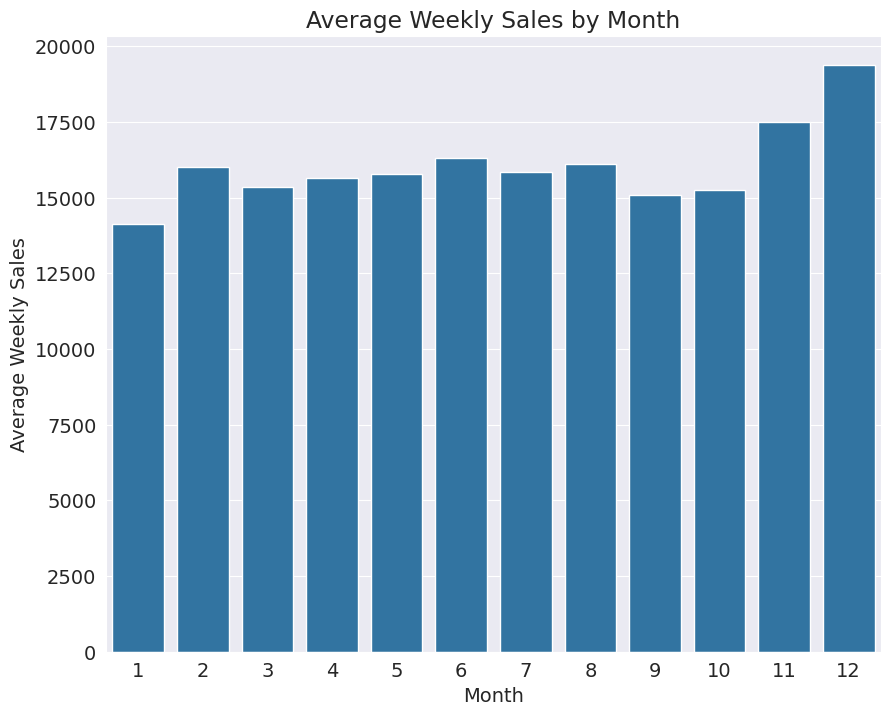

In [34]:
avg_sales_by_month = train_data.groupby('Month')['Weekly_Sales'].mean().reset_index()
sns.barplot(data=avg_sales_by_month, x='Month', y='Weekly_Sales')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Month')
plt.show()

**Insights** - Months 11 and 12 seem to have highest recorded weekly sales.

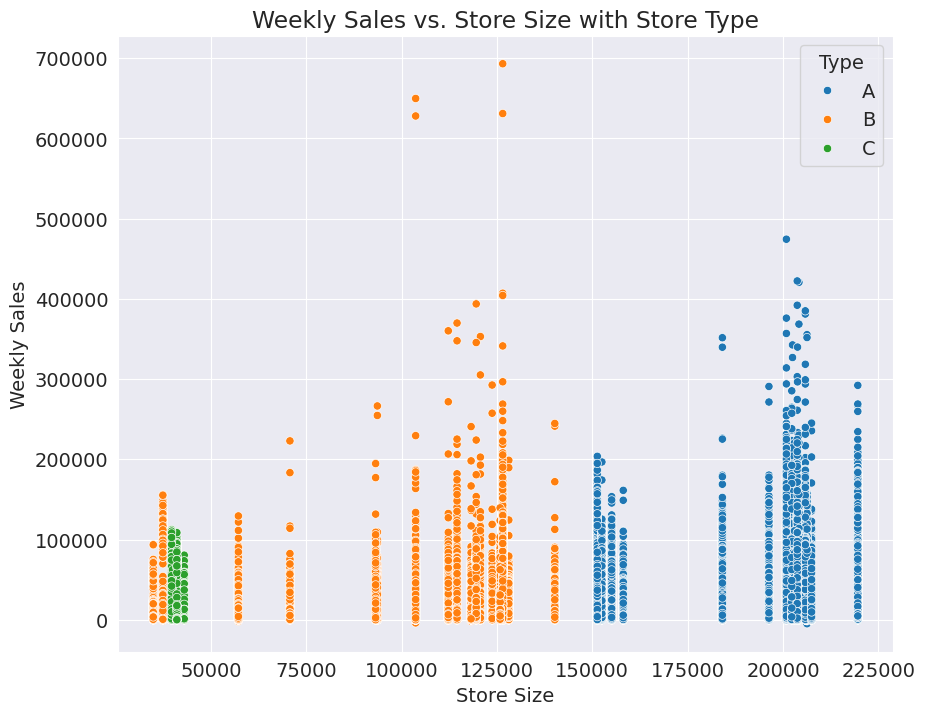

In [35]:
sns.scatterplot(data=train_data, x='Size', y='Weekly_Sales', hue='Type')
plt.xlabel('Store Size')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales vs. Store Size with Store Type')
plt.show()

**Insights** - Store type A are bigger Walmarts and therefore it makes sense that they record highest weekly sales

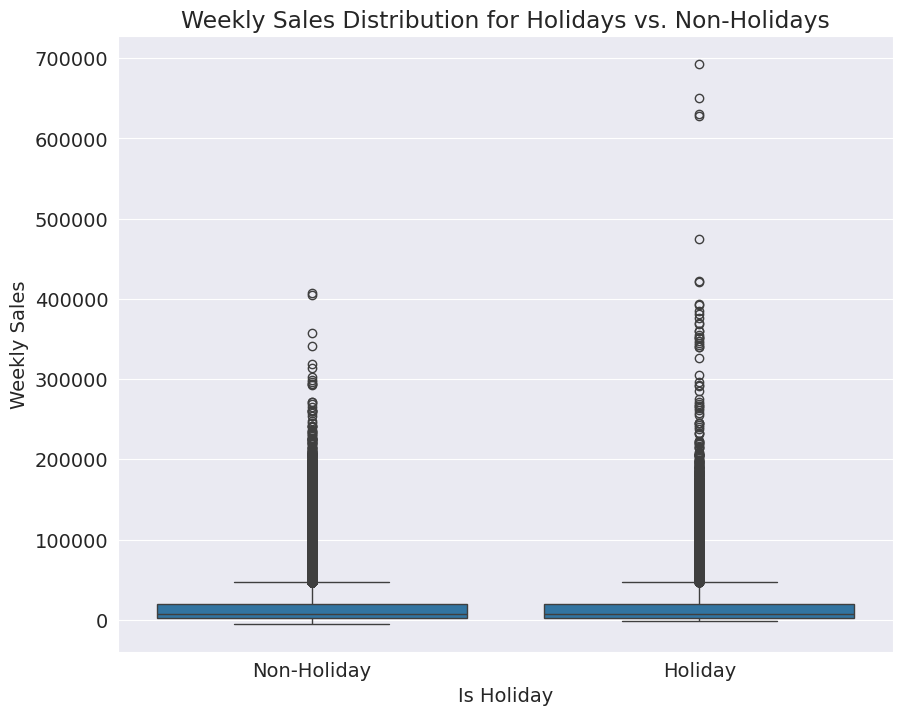

In [36]:
sns.boxplot(data=train_data, x='IsHoliday', y='Weekly_Sales')
plt.xlabel('Is Holiday')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Distribution for Holidays vs. Non-Holidays')
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.show()

**Insights** - Holiday weeks have more high weekly sales outliers compared to non-holiday weeks

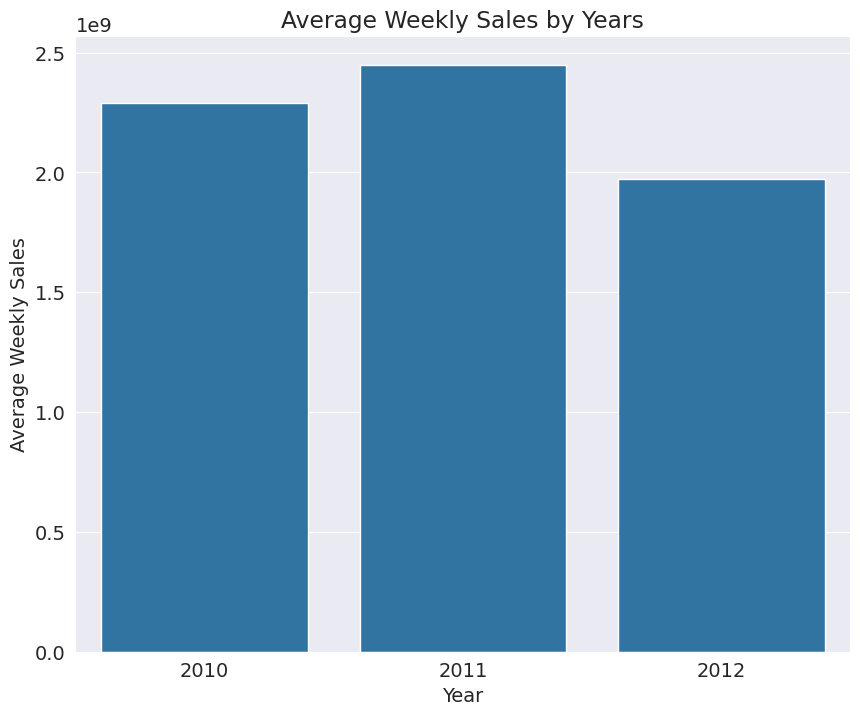

In [37]:
avg_sales_by_year = train_data.groupby('Year')['Weekly_Sales'].sum().reset_index()
# Plot the average weekly sales by years
sns.barplot(data=avg_sales_by_year, x='Year', y='Weekly_Sales')
plt.xlabel('Year')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Years')
plt.show()

**Insights** - 2011 is the year that has recorded highest weekly sales

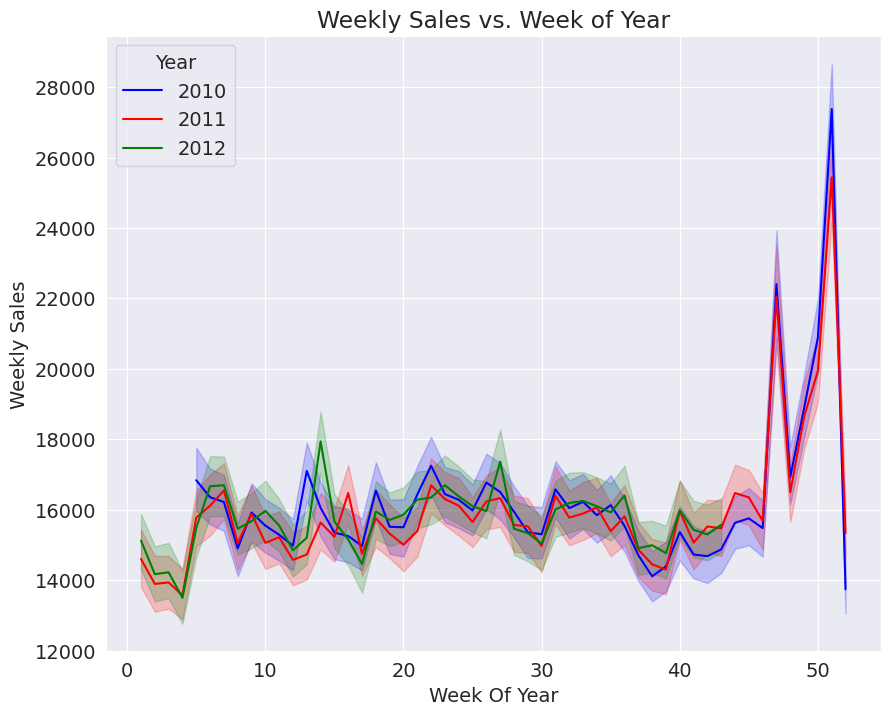

In [38]:
sns.lineplot(train_data, x = 'WeekOfYear', y = 'Weekly_Sales', hue = 'Year', palette = ['blue', 'red', 'green'])
plt.xlabel('Week Of Year')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales vs. Week of Year')
plt.show()

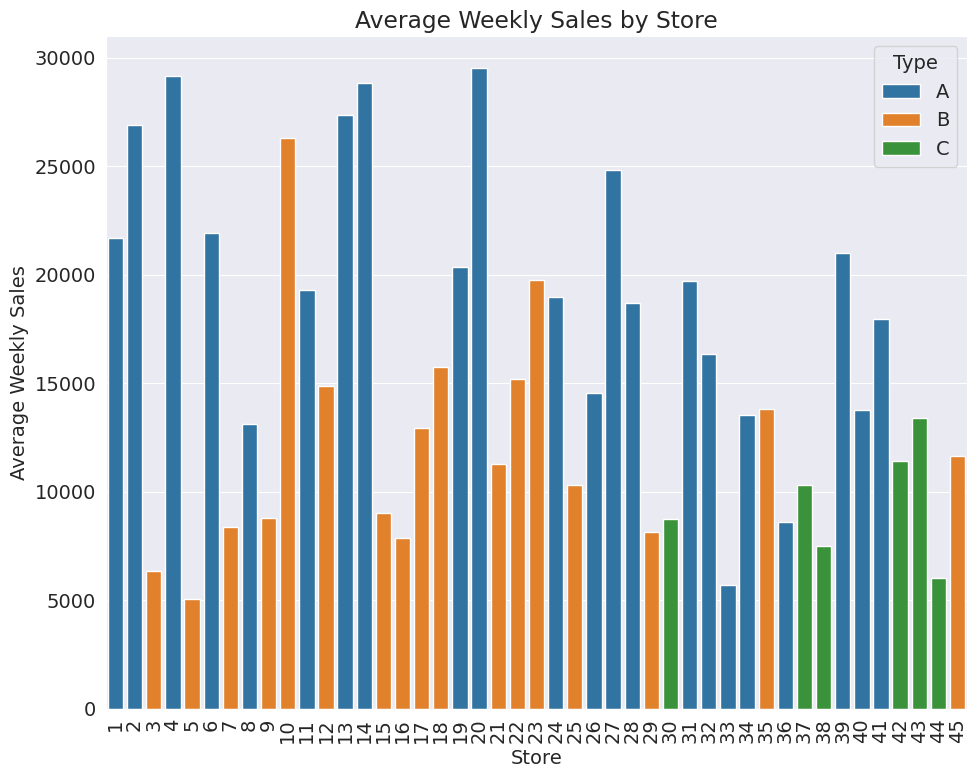

In [39]:
avg_sales_by_store = train_data.groupby(['Store','Type'])['Weekly_Sales'].mean().reset_index()
sns.barplot(data=avg_sales_by_store, x='Store', y='Weekly_Sales', hue = 'Type')
plt.xlabel('Store')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales by Store')
plt.xticks(rotation=90)  # Rotate X-axis labels by 45 degrees
plt.tight_layout()  # Adjust layout to prevent label overlapping
plt.show()

### Splitting given train data into training and validation data

We will do a rough 75-25 split for the training and validation data.

In [40]:
train_size = int(.75 * len(train_data))
train_df,val_df = train_data[:train_size], train_data[train_size:]

In [41]:
len(train_df), len(val_df)

(315001, 105001)

### Identifying input and target columns

In [42]:
input_cols = ['Store', 'Dept', 'IsHoliday', 'Temperature','Fuel_Price', 'CPI', 'Unemployment', 'Type', 'Size', 'Day', 'Month','Year', 'WeekOfYear', 'Quarter', 'MarkDown']
target_col = ['Weekly_Sales']

In [43]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_data[input_cols].copy()

### Identifying numeric and categorical columns

In [44]:
def num_cat_cols(data):

    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = data.select_dtypes('object').columns.tolist()

    return numeric_cols, categorical_cols

In [45]:
numeric_cols, categorical_cols = num_cat_cols(train_inputs)

In [46]:
numeric_cols, categorical_cols

(['Store',
  'Dept',
  'IsHoliday',
  'Temperature',
  'Fuel_Price',
  'CPI',
  'Unemployment',
  'Size',
  'Day',
  'Month',
  'Year',
  'WeekOfYear',
  'Quarter',
  'MarkDown'],
 ['Type'])

In [47]:
numeric_cols, categorical_cols = num_cat_cols(train_inputs)

### Imputation, Scaling and Encode

In [48]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
imputer = SimpleImputer(strategy='mean').fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

scaler = MinMaxScaler().fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

X_train = train_inputs[numeric_cols+encoded_cols]
X_val = val_inputs[numeric_cols+encoded_cols]
X_test = test_inputs[numeric_cols+encoded_cols]

In [49]:
from sklearn.impute import SimpleImputer

In [50]:
imputer = SimpleImputer(strategy='mean').fit(train_inputs[numeric_cols])

In [51]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [52]:
from sklearn.preprocessing import MinMaxScaler

In [53]:
scaler = MinMaxScaler().fit(train_inputs[numeric_cols])

In [54]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [55]:
from sklearn.preprocessing import OneHotEncoder

In [56]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [57]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [58]:
X_train = train_inputs[numeric_cols+encoded_cols]
X_val = val_inputs[numeric_cols+encoded_cols]
X_test = test_inputs[numeric_cols+encoded_cols]

# Implement and Train ML models

### Linear Models

In [59]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

In [60]:
linear_models_scores = {}

In [61]:
def try_linear_models(model_name, model):

    model.fit(X_train, train_targets) # training the model on training data
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val) # model predictions on validation data

    # Training prediction scores
    train_mae = mean_absolute_error(train_targets, train_preds)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    train_r2 = r2_score(train_targets, train_preds)
    # validation prediction scores
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    val_r2 = r2_score(val_targets, val_preds)

    linear_models_scores[model_name] = {'mae':[round(train_mae,2), round(val_mae,2)],'rmse':[round(train_rmse,2), round(val_rmse,2)],'r2':[round(train_r2,2), round(val_r2,2)]}

    return val_mae, val_rmse, val_r2

In [62]:
model_names = ['linear', 'ridge', 'lasso', 'elasticnet', 'sgd']
models = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), SGDRegressor()]

for i in range(len(models)):

    val_mae, val_rmse, val_r2 = try_linear_models(model_names[i], models[i])

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

In [63]:
pd.DataFrame(linear_models_scores)

,linear,ridge,lasso,elasticnet,sgd
mae,"[14604.07, 14375.72]","[14603.74, 14365.38]","[14602.96, 14368.69]","[14848.26, 14709.18]","[14546.25, 14247.11]"
rmse,"[21894.9, 20931.1]","[21895.32, 20929.3]","[21895.74, 20928.6]","[22460.49, 21522.96]","[21899.33, 20939.12]"
r2,"[0.09, 0.1]","[0.09, 0.1]","[0.09, 0.1]","[0.04, 0.04]","[0.09, 0.1]"


### Ensemble Models

In [64]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [65]:
rf_scores = {}
gb_scores = {}
ab_scores = {}
xgb_scores = {}
lgbm_scores = {}
trained_models = {}

In [66]:
def try_ensemble_methods(model_name, model, score_dict):

    model.fit(X_train, train_targets.values.ravel())

    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Training prediction scores
    train_mae = mean_absolute_error(train_targets, train_preds)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    train_r2 = r2_score(train_targets, train_preds)
    # validation prediction scores
    val_mae = mean_absolute_error(val_targets, val_preds)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    val_r2 = r2_score(val_targets, val_preds)

    score_dict['mae'] = {'training':round(train_mae,2), 'validation': round(val_mae,2)}
    score_dict['rmse'] = {'training':round(train_rmse,2), 'validation': round(val_rmse,2)}
    score_dict['r2'] = {'training':round(train_r2,2), 'validation': round(val_r2,2)}

    trained_models[model_name] = model

    return val_mae, val_rmse, val_r2

In [67]:
ensemble_models = [RandomForestRegressor(random_state=42, n_jobs=-1),
                  GradientBoostingRegressor(random_state=42),
                  AdaBoostRegressor(random_state=42),
                  XGBRegressor(random_state=42, n_jobs=-1),
                  LGBMRegressor(random_state=42, n_jobs=-1)]
ensemble_model_names = ['random_forest','gradient_boosting',
                       'adaboost','xgboost','lightgbm']
score_dicts = [rf_scores,gb_scores, ab_scores, xgb_scores, lgbm_scores]


for i in range(5):

    val_mae, val_rmse, val_r2 = try_ensemble_methods(ensemble_model_names[i], ensemble_models[i], score_dicts[i])
    print("*********")
    print(ensemble_model_names[i])
    print("Val MAE: ", val_mae)
    print("Val RMSE: ", val_rmse)
    print("Val R2: ", val_r2)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


*********
random_forest
Val MAE:  1977.2589584489672
Val RMSE:  4233.994444845007
Val R2:  0.9630089089391377


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


*********
gradient_boosting
Val MAE:  6645.801504012036
Val RMSE:  10485.406396490489
Val R2:  0.773135204167315


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


*********
adaboost
Val MAE:  18950.618641914134
Val RMSE:  22551.49097337899
Val R2:  -0.049414579980671336


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


*********
xgboost
Val MAE:  3295.9193438399034
Val RMSE:  5456.511047299211
Val R2:  0.9385634738617817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1527
[LightGBM] [Info] Number of data points in the train set: 315001, number of used features: 17
[LightGBM] [Info] Start training from score 16042.567405
*********
lightgbm
Val MAE:  4076.937869151614
Val RMSE:  6641.314942397845
Val R2:  0.9089867286485401


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Feature importance

In [68]:
rf = trained_models['random_forest']
xgb = trained_models['xgboost']
lgbm = trained_models['lightgbm']

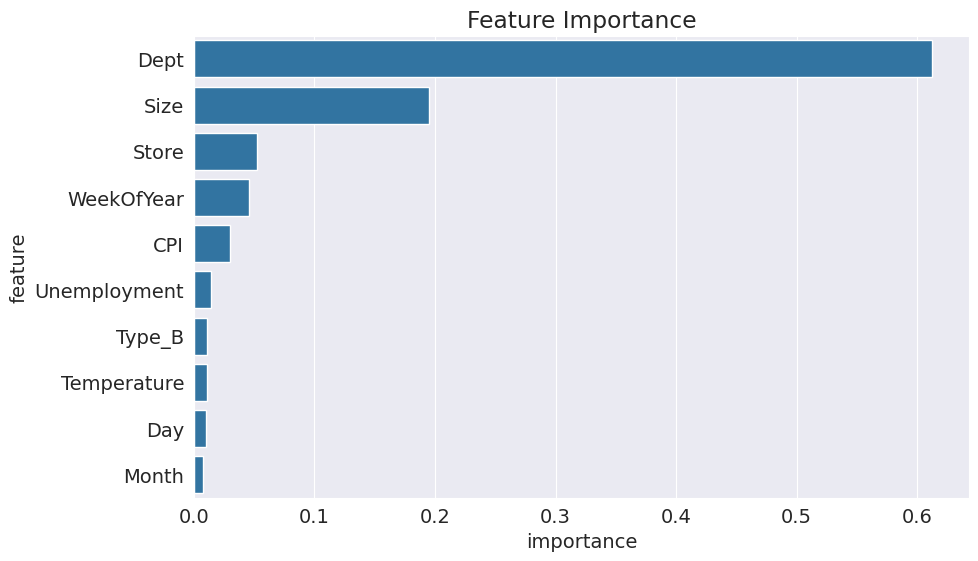

In [70]:
rf_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=rf_imp_df.head(10), x='importance', y='feature');

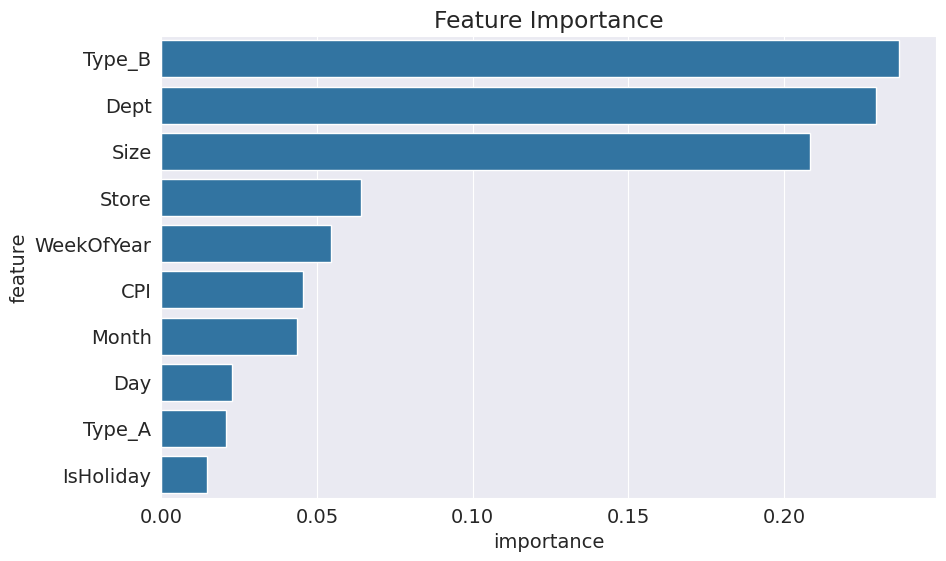

In [71]:
xgb_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=xgb_imp_df.head(10), x='importance', y='feature');

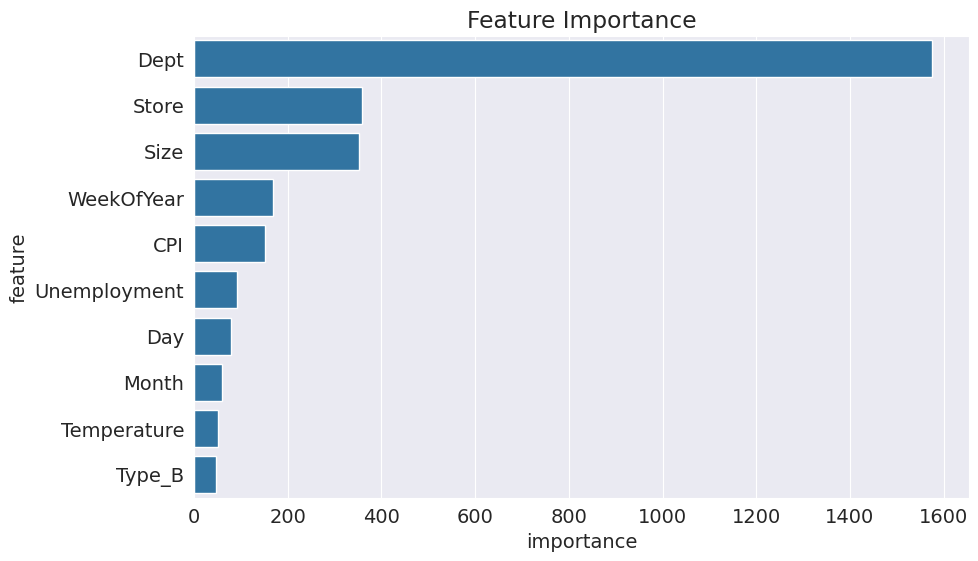

In [72]:
lgbm_imp_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=lgbm_imp_df.head(10), x='importance', y='feature');

### The top performing models are Random Forest, XGBoost and LightGBM. I shall now perform Hyperparameter tuning on these models

In [73]:
# from sklearn.model_selection import GridSearchCV, KFold

In [74]:
def weighted_mean_absolute_error(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

In [75]:
train_weights = np.where(X_train['IsHoliday'] == 1, 5, 1)
val_weights = np.where(X_val['IsHoliday'] == 1, 5, 1)

In [76]:
models = {
    'randomforest': {
        'model': RandomForestRegressor,
        'params': {
            'max_depth': [5, 10, 15, 20, 25, 30, None],
            'n_estimators': [20, 50, 100, 150, 200, 250, 300,500],
            'min_samples_split': [2, 3, 4, 5, 10]
        }
    },
    'xgboost': {
        'model': XGBRegressor,
        'params': {
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
            'n_estimators': [30, 50, 100, 150, 200, 250, 300, 500],
            'learning_rate': [0.3, 0.2, 0.1, 0.01, 0.001]
        }
    },
    'lightgbm': {
        'model': LGBMRegressor,
        'params': {
            'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
            'n_estimators': [30, 50, 100, 150, 200, 250, 300, 500],
            'learning_rate': [0.3, 0.2, 0.1, 0.01, 0.001]
        }
    }
}

In [77]:
results = {}

def test_params(model_type, model, **params):
    model_instance = model(**params)
    model_instance.fit(X_train, train_targets)
    train_wmae = weighted_mean_absolute_error(model_instance.predict(X_train), train_targets, train_weights)
    val_wmae = weighted_mean_absolute_error(model_instance.predict(X_val), val_targets, val_weights)

    return train_wmae, val_wmae

def test_param_and_plot(model_type, model, param_name, param_values):

    train_errors, val_errors = [], []
    wmae_results = {}

    for value in param_values:
        params = {param_name: value}
        train_wmae, val_wmae = test_params(model_type, model, **params)

        train_errors.append(train_wmae)
        val_errors.append(val_wmae)

    plt.figure(figsize=(10, 6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('WMAE')
    plt.legend(['Training', 'Validation'])

    wmae_results[param_name] = {
            'train_wmae': train_errors,
            'val_wmae': val_errors
        }

    return wmae_results

In [79]:
# Iterate over each model type
for model_type, config in models.items():
    model = config['model']
    params = config['params']

    # Iterate over each parameter and its values
    for param_name, param_values in params.items():
        wmae_results = test_param_and_plot(model_type, model, param_name, param_values)
        results[model_type + '_' + param_name] = wmae_results

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ValueError: Unable to coerce to Series, length must be 1: given 315001